In [2]:
import numpy as np
import torch
from torchvision import transforms, datasets
from torchvision.utils import save_image

import unsplit.attacks as unsplit
from unsplit.models import *
from unsplit.util import *

### AUGMENTATIONS

In [68]:
split_layer = 2
dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

In [69]:
for batch in trainloader:
    print(batch[0].shape)
    break

torch.Size([64, 1, 28, 28])


In [70]:
augmented_trasnforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
augmented_testset = datasets.MNIST('data/mnist', download=True, train=False, transform=augmented_trasnforms)

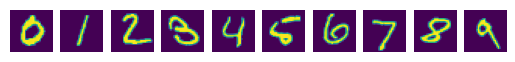

In [71]:
ims = [get_examples_by_class(testset, c, count=1) for c in range(10)]
display_imagelist(ims, 28, 28)

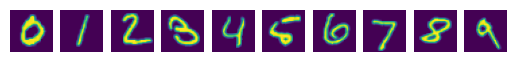

In [77]:
COUNT = 1

inversion_targets = [get_examples_by_class(augmented_testset, c, count=COUNT) for c in range(10)]
augmented_targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 32, 32)

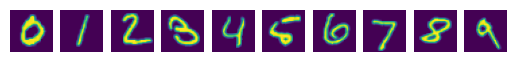

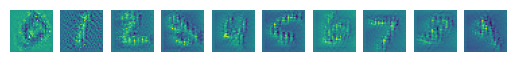

In [38]:
results, losses = [], []
for idx, target in enumerate(augmented_targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 32, 32) # 28 28
    display_imagelist(results, 32, 32) # 28 28

In [39]:
augmented_trasnforms = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
augmented_testset = datasets.MNIST('data/mnist', download=True, train=False, transform=augmented_trasnforms)

In [42]:
augmented_testset[0][0].shape

torch.Size([1, 64, 64])

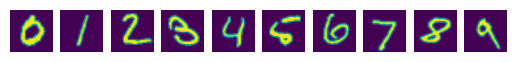

In [43]:
COUNT = 1
inversion_targets = [get_examples_by_class(augmented_testset, c, count=COUNT) for c in range(10)]
augmented_targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
display_imagelist(inversion_targets, 64, 64)

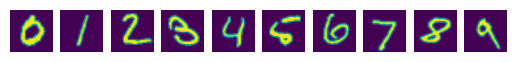

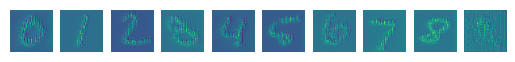

In [44]:
results, losses = [], []
for idx, target in enumerate(augmented_targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 64, 64) # 28 28
    display_imagelist(results, 64, 64) # 28 28

#### with training

In [47]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')


Epoch: 0 Loss: 0.32459959387779236 Acc: 96.69785360484315
Epoch: 1 Loss: 0.08627594262361526 Acc: 97.57575757575758
Epoch: 2 Loss: 0.06092633306980133 Acc: 98.19672131147541
Epoch: 3 Loss: 0.04698646441102028 Acc: 98.00108049702864
Epoch: 4 Loss: 0.03844796121120453 Acc: 98.46322722283205
Epoch: 5 Loss: 0.03173432871699333 Acc: 98.39779005524862
Epoch: 6 Loss: 0.028777405619621277 Acc: 98.51485148514851
Epoch: 7 Loss: 0.023382358253002167 Acc: 98.47991313789359
Epoch: 8 Loss: 0.021692944690585136 Acc: 99.34029686641011
Epoch: 9 Loss: 0.0175878144800663 Acc: 98.7417943107221


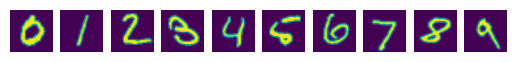

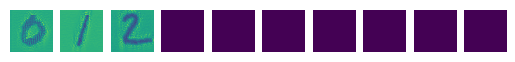

In [48]:
results, losses = [], []
for idx, target in enumerate(augmented_targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 64, 64) # 28 28
    display_imagelist(results, 64, 64) # 28 28

print(f"Average MSE: {sum(losses) / len(losses)}")
print(f"Clone test score: {get_test_score(client, clone, augmented_testset, split=split_layer)}%")

In [51]:
print(f"Average MSE: {sum(losses) / len(losses)}")

Average MSE: 0.10147987306118011


In [53]:
print(f"Clone test score: {get_test_score(client, clone, testset, split=split_layer)}%")

Clone test score: 10.534934497816593%


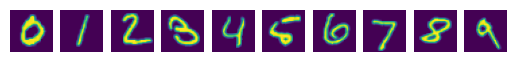

In [50]:
augmented_trasnforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
augmented_testset = datasets.MNIST('data/mnist', download=True, train=False, transform=augmented_trasnforms)
COUNT = 1
inversion_targets = [get_examples_by_class(augmented_testset, c, count=COUNT) for c in range(10)]
augmented_targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
display_imagelist(inversion_targets, 32, 32)

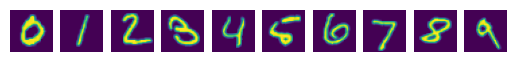

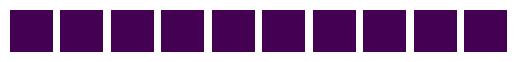

In [56]:
results, losses = [], []
for idx, target in enumerate(augmented_targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 32, 32) # 28 28
    display_imagelist(results, 32, 32) # 28 28

In [57]:
print(f"Average MSE: {sum(losses) / len(losses)}")
print(f"Clone test score: {get_test_score(client, clone, testset, split=split_layer)}%")

Average MSE: 0.09928103536367416
Clone test score: 10.905125408942203%


In [60]:
results[0]

tensor([[[[3.2175e-40, 3.2175e-40, 3.2175e-40,  ..., 3.2175e-40,
           3.2175e-40, 3.2175e-40],
          [3.2175e-40, 3.2175e-40, 3.2175e-40,  ..., 3.2175e-40,
           3.2175e-40, 3.2175e-40],
          [3.2175e-40, 3.2175e-40, 3.2175e-40,  ..., 3.2175e-40,
           3.2175e-40, 3.2175e-40],
          ...,
          [3.2175e-40, 3.2175e-40, 3.2175e-40,  ..., 3.2175e-40,
           3.2175e-40, 3.2175e-40],
          [3.2175e-40, 3.2175e-40, 3.2175e-40,  ..., 3.2175e-40,
           3.2175e-40, 3.2175e-40],
          [3.2175e-40, 3.2175e-40, 3.2175e-40,  ..., 3.2175e-40,
           3.2175e-40, 3.2175e-40]]]])

normal example

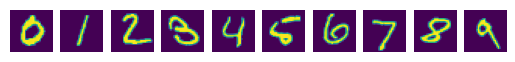

In [73]:
COUNT = 1
inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()
display_imagelist(inversion_targets, 28, 28)

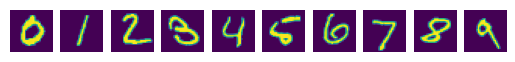

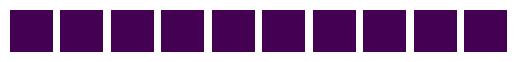

In [67]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28) # 28 28
    display_imagelist(results, 28, 28) # 28 28

In [76]:
for i, t in enumerate(targetloader):
    print(t.size())
    break

torch.Size([1, 1, 28, 28])


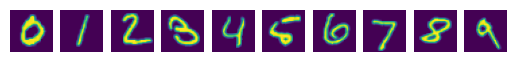

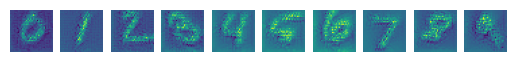

In [82]:
results, losses = [], []
for idx, target in enumerate(augmented_targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out,  torch.Size([1, 1, 32, 32]), main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 32, 32) # 28 28
    display_imagelist(results, 32, 32) # 28 28